In [1]:
from tqdm import tqdm
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import utils
from datasets import CommentsDataset, CommentTagsDataset, NLIDataset
from models import BERTCls, SimplePerceptron

from sklearn.metrics.pairwise import cosine_similarity, euclidean_distances
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score

from transformers import AutoModel, AutoTokenizer, BertForSequenceClassification, BertModel, BertForNextSentencePrediction, AutoModelForSequenceClassification

import torch

from torch import nn
from torch.utils.data import DataLoader

TAGS = [
    'ASSORTMENT',
    'CATALOG_NAVIGATION',
    'DELIVERY',
    'PAYMENT',
    'PRICE',
    'PRODUCTS_QUALITY',
    'PROMOTIONS',
    'SUPPORT',
]

CLASSES = [f'trend_id_res{i}' for i in range(50)]

CLASSES2TRENDS = {0: 'Долгая доставка',
 1: 'Доставка стала долгой',
 2: 'Время доставки не соответствует заявленому',
 3: 'Регулярные опоздания',
 4: 'Не отследить реальное время доставки',
 5: 'Курьер на карте',
 6: 'Нет доставки по адресу',
 7: 'Не предупреждаем об удалении товара',
 8: 'Высокая минимальная сумма заказа',
 9: 'Сумма заказа меняется во время набора корзины',
 10: 'Минимальная сумма заказа',
 11: 'Товары с подходящим сроком годности',
 12: 'Высокие цены',
 13: 'Не довезли товар',
 14: 'Товар испорчен во время доставки',
 15: 'Просроченные товары',
 16: 'Замечания по работе курьеров',
 17: 'Не читаем комментарии',
 18: 'Спасибо',
 19: 'Нет смысла',
 20: 'Всё нормально',
 21: 'Всё плохо',
 22: 'Скидки для постоянных клиентов',
 23: 'Больше акций/скидок',
 24: 'Скидка/промокод распространяется не на все товары',
 25: 'Непонятно как работает скидка',
 26: 'Не сработала скидка/акция/промокод',
 27: 'Качество товаров',
 28: 'Маленький ассортимент',
 29: 'Нет в наличии товара',
 30: 'Качество поддержки',
 31: 'Замечания по работе сборщика',
 32: 'Отменили заказ',
 33: 'Знание русского языка',
 34: 'Привезли чужой заказ',
 35: 'Долго на сборке',
 36: 'Сравнивают с конкурентами',
 37: 'Скидки за опоздание',
 38: 'Курьеры отменяют заказ',
 39: 'Не тянет на тенденцию',
 40: 'Испорченные товары',
 41: 'Не нравится интерфейс приложения',
 42: 'Приложение зависает',
 43: 'Быстрая доставка',
 44: 'Условия работы курьеров',
 45: 'СберСпасибо',
 46: 'Время работы',
 47: 'Неудобный поиск',
 48: 'Платежи',
 49: 'Возврат денег'}
CLASSES2FULLTRENDS = {
    0: 'Долгая доставка, долго везёте. Долго. Приезжает через час. Дольше часа. Опоздания. Время. Слишком долгая доставка. Убрали быструю доставку. Задержки. Неторопливо. Не дождаться. Жду. Доставляют не вовремя',
    1: 'Доставка стала долгой, раньше доставляли быстрее. Раньше доставка была быстрая. Стали доставлять от [NUM] минут. Стало дольше. Было быстро. Сейчас долго. Скорость доставки ухудшилась',
    2: 'Не соответствует заявленому времени доставки. Дольше чем указано. Пишите [NUM] мин, а везёте [NUM] мин. Обещания в [NUM]м. Заявленных [NUM] минут доставку. Дольше, чем обещали. Обман с доставкой, доставка за [NUM] мин',
    3: 'Регулярные опоздания, каждый заказ привозят с опозданием, доставка постоянно задерживается. Частые опоздания. Иногда задерживается. Каждый раз жду. Каждый раз не вовремя. Переодически очень долго везут заказ.',
    4: 'Не отследить реальное время доставки, невозможно понять, когда приедет заказ. Неудобно следить за доставкой. Нет понимания точного времени прибытия курьера. Время ожидания не соответствует',
    5: 'Курьер на карте, отображение курьера на карте, курьера на карте не видно, отслеживать курьера. Когда будет заказ?',
    6: 'Нет доставки по адресу, границы доставки, не везде доставляем',
    7: 'Не предупреждаете об удалении товара, нет замену товара, товар удалили из заказа, убрали из заказа. На этапе сборки. Не предупредили об отмене. Нет возможности заменить товар. Отмена товара.',
    8: 'Высокая минимальная сумма заказа, дорогая доставка, заказ от большой суммы',
    9: 'Сумма заказа меняется во время набора корзины, приходится несколько раз докладывать товары до минимальной суммы',
    10: 'Минимальная сумма заказа, наличие минимальной определенной стоимости, меняется минимальная сумма. Заказ от [NUM] рублей',
    11: 'Товары с подходящим сроком годности, привозим товары с практически истекшим сроком годности, конец срока годности', 
    12: 'Высокие цены, дорого, цена отличается от других. Необоснованные цены. Неудобная стоимость',
    13: 'Не довезли товар, забыли положить, не доложили. Не доставили заказ. Не хватает продуктов',
    14: 'Товар испорчен во время доставки: побили яйца, разлился йогрут, порваная упаковка, разлившееся, раздавленные. Повреждения во время доставки',
    15: 'Просроченные продукты, привезли товар с истекшим сроком годности, просрочка. Несвежие товары',
    16: 'Замечания по работе курьеров. Курьеры хамят, не читают комментарии, не понимают русский язык, не доносят заказ до двери. Не компетентные, безответственные курьеры',
    17: 'Не читаем комментарии, не выполнили комментарий. Игнорируем замечание к заказу',
    18: 'Спасибо, молодцы так деражть, 👍🏻, ❤️. Благодарю сервис. Отлично, хороший сервис. Классно, супер. Удобно, здорово, быстро. Ок, пойдет. Норм',
    19: 'Нет смысла, не ясен смысл. ?, . хз, не знаю, ок, хуй ня, гавно, бубу, охуели, ???',
    20: 'Всё нормально. Все норм, нормально, устраивает, неплохо. Пойдет, ничего, ок. Все хорошо',
    21: 'Всё плохо. Плохой сервис, все хуево. Хуета. Портитесь. Ничего хорошего, отвратительно, хуже некуда',
    22: 'Нет скидок для постоянных клиентов, скидок на следующий заказ, программы лояльности. Персональные скидки, акции, промоакции, бонусы, промокоды, специальные предложения',
    23: 'Больше акций/скидок/промокодов. Не хватает скидок на всю корзину, акцию "товар за 1 рубль". Мало акций/скидок',
    24: 'Скидка/промокод распространяется не на все товары. Не применяются скидки, промокоды. Не применяется корзинная скидка, корзинная скидка применяется только к какой-то категории товаров',
    25: 'Непонятно как работает скидка, странно работает скидка, не понятно почему скидка применилась не ко всем товарам, не понятно к каким товарам применилась скидка',
    26: 'Не сработала скидка/акция/промокод. Не работает скидка. Не работает промокод. Не действует промокод. Списались баллы',
    27: 'Качество товаров. Некачественные товары. Невкусно. Несвежее, вялое, неспелое. Есть невозможно. Испорчен',
    28: 'Маленький ассортимент, маленький выбор товаров. Ассортимент расстраивает. Нехватка, отсутствует товар, мало товаров. Мало продуктов. Расширьте ассортимент.',
    29: 'Нет в наличии товара, товары быстро заканчиваются, нет завоза. Ничего нет вечером, уведомление о поступлении, поступит ли товар снова. Товар раскупили',
    30: 'Качество поддержки. Медленно отвечаем, бот не переключает на оператора, закрываем обращения не разобравшись. Поддержка плохая. Молчат, не отвечают',
    31: 'Сборщик. Сборщик не положил. Забыли положить. Несовместимые продукты в один пакет, термопакеты для замороженных продуктов, кладём не то, путаем товары. Плохая сборка продуктов',
    32: 'Отменили заказ, не довозят заказ. Заказ отменён',
    33: 'Знание русского языка, курьеры не понимают/не читают/не говорят по-русски, хачи, узбеки. Ни слова ни понимают. Не русские. Не умеют читать. Грязные представители южных стран',
    34: 'Привезли чужой заказ, перепутали заказ. Путаница с заказами. Привозят не твой заказ. Не мой заказ',
    35: 'Сборка заказа. Долго на сборке, долго собираем заказ. Заказ ещё не передали. Ждём, а курьер ещё не вышел',
    36: 'Сравнивают с конкурентами, сравнение с другими сервисами доставки продуктов. Проигрывает пяторчке. Сбермаркет выгоднее. Яндекс и деливери лучше. Яндекс еда. Лавка, озон фреш. Вкусвилл быстрее',
    37: 'Скидки за опоздание, скидки/компенсацию в качестве извинения, не компенсирует. Компенсация. Бонусы за задержку. Скидка на след заказ',
    38: 'Курьеры отменяют заказ, курьер молча отменяет заказ. Он уже отменил заказ',
    39: 'Не тянет на тенденцию', # будем ставить только когда все 0
    40: 'Испорченные товары, срок годности, тухлое, гнилые, пропавшая, плесень',
    41: 'Не нравится интерфейс приложения, не нравится приложение. Неудобный дизайн, расположение категорий. Неинтуитивное непонятное управление. Неудобно пользоваться. Добавьте раздел, редактировать заказ.',
    42: 'Приложение зависает, приложение работает не стабильно, зависает. Приложение тупит, глючит. Тормозит. Андроид фризит, айос.',
    43: 'Быстрая доставка, быстро доставили, скорость доставки',
    44: 'Условия работы курьеров, повысить ставку курьерам, одеть потеплее. Плохое отношение к сотрудникам. Ужасное обращение с сотрудниками. Больше внимания к курьерам и их условиям. Перерыв работникам',
    45: 'СберСпасибо, сложности при подключении, периодически не оплатить бонусами. Бонусы спасибо. Бонусы Сбербанкспасибо. Баллы Сбер Спасибо.',
    46: 'Время работы, рано закрываетесь, круглосуточная доставка, сделайте доставку с [NUM] часов. Работаете с [NUM] часов утра. Не работаете после [NUM] часов',
    47: 'Неудобный поиск, не нравится навигация по каталогу, не нравится структура каталога. Сторисы в каталоге, акции среди товаров. Не хватает фильтров для поиска. Поиск по приложению',
    48: 'Платежи, жалобы на проведение платежей, оплата курьеру наличными или картой, проблемы с оплатой, СБП, отображение карты, не проходят платежи, чеки, квитанции',
    49: 'Возврат денег, долгие возвраты. Не вернули деньги. Не возвращают деньги. Не вернули деньги за прошлый заказ'
}
device = 'cuda:0'

### BERT - best model recreation

In [2]:
model_name = 'ai-forever/ruElectra-large'
model_name = 'ai-forever/ruRoberta-large'
# model_name = 'deepvk/deberta-v1-base'
model_name = 'ai-forever/rubert-tiny2'
model_name = 'cointegrated/rubert-base-cased-nli-twoway'
model_name = 'ai-forever/ruBert-large'
model = BERTCls(AutoModel.from_pretrained(model_name))
tokenizer = AutoTokenizer.from_pretrained(model_name)

In [3]:
df = pd.read_csv('data/train.csv')
df = utils.prepare_data(df)
# df['tags'] = df['tags'].replace(float('nan'), '{NONE}')
df

,index,assessment,tags,text,SUPPORT,CATALOG_NAVIGATION,ASSORTMENT,PROMOTIONS,PAYMENT,DELIVERY,...,trend_id_res41,trend_id_res42,trend_id_res43,trend_id_res44,trend_id_res45,trend_id_res46,trend_id_res47,trend_id_res48,trend_id_res49,NONE
0,5652,6.0,"{ASSORTMENT,PROMOTIONS,DELIVERY}","Маленький выбор товаров, хотелось бы ассортиме...",0,0,1,1,0,1,...,0,0,0,0,0,0,0,0,0,NaN
1,18092,4.0,"{ASSORTMENT,PRICE,PRODUCTS_QUALITY,DELIVERY}",Быстро,0,0,1,0,0,1,...,0,0,0,0,0,0,0,0,0,NaN
2,13845,6.0,"{DELIVERY,PROMOTIONS,PRICE,ASSORTMENT,SUPPORT}",Доставка постоянно задерживается,1,0,1,1,0,1,...,0,0,0,0,0,0,0,0,0,NaN
3,25060,6.0,"{PRICE,PROMOTIONS,ASSORTMENT}",Наценка и ассортимент расстраивают,0,0,1,1,0,0,...,0,0,0,0,0,0,0,0,0,NaN
4,1428,6.0,"{PRICE,PROMOTIONS}",Можно немного скинуть минимальную сумму заказа...,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4618,26325,2.0,{PRODUCTS_QUALITY},Привезли прокисший суп,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,NaN
4619,661,6.0,{DELIVERY},пойдет,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,NaN
4620,1870,6.0,"{PROMOTIONS,PRICE,SUPPORT,PRODUCTS_QUALITY}",Не дают абузить поддержка не возвращает деньги...,1,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,NaN
4621,22650,2.0,"{DELIVERY,PRODUCTS_QUALITY}","Очень плохая доставка в первую очередь, постоя...",0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,NaN


In [4]:
test_df = pd.read_csv('data/test.csv')
test_df = utils.prepare_data(test_df)
test_df

,index,assessment,tags,text,SUPPORT,CATALOG_NAVIGATION,ASSORTMENT,PROMOTIONS,PAYMENT,DELIVERY,PRICE,PRODUCTS_QUALITY,NONE
0,3135,3.0,{DELIVERY},"Последнее время думаю плохо, сроки доставки да...",0,0,0,0,0,1,0,0,NaN
1,4655,2.0,"{PRICE,DELIVERY,ASSORTMENT}",Цены намного выше магазинных но радуют акции,0,0,1,0,0,1,1,0,NaN
2,22118,2.0,"{CATALOG_NAVIGATION,ASSORTMENT,DELIVERY}","Доставка за [NUM] минут, заказ даже не начали ...",0,1,1,0,0,1,0,0,NaN
3,23511,0.0,{DELIVERY},Ужасно долгая доставка,0,0,0,0,0,1,0,0,NaN
4,45,6.0,"{ASSORTMENT,PROMOTIONS}",Добрый вечер! Вы большие молодцы. Меня всё уст...,0,0,1,1,0,0,0,0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
9010,3523,3.0,"{PRICE,SUPPORT,DELIVERY}",Задержка с доставкой не даете промокод на скид...,1,0,0,0,0,1,1,0,NaN
9011,24925,6.0,"{PRICE,PRODUCTS_QUALITY,ASSORTMENT}",Очень удобный формат сервиса и очень маленький...,0,0,1,0,0,0,1,1,NaN
9012,6327,6.0,"{PAYMENT,ASSORTMENT,DELIVERY}","Сумма заказа почти всегда высокая, что зачасту...",0,0,1,0,1,1,0,0,NaN
9013,530,3.0,"{PRODUCTS_QUALITY,SUPPORT,DELIVERY}","Часто, заказываю у вас молочную продукцию, при...",1,0,0,0,0,1,0,1,NaN


In [5]:
EPOCHS = 35
BATCH_SIZE = 20
train_df, val_df = train_test_split(df, test_size=0.2, random_state=42)


train_data = CommentsDataset(train_df, tokenizer=tokenizer)
val_data = CommentsDataset(val_df, tokenizer=tokenizer)
test_data = CommentsDataset(test_df, tokenizer=tokenizer, is_test=True)
train_dataloader = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True)
val_dataloader = DataLoader(val_data, batch_size=128)
test_dataloader = DataLoader(test_data, batch_size=128)
val_data=[x['label'] for x in list(val_data)]

# for param in model.backbone.bert.parameters():
#     param.requires_grad = False
    
model = model.to(device)
optimizer = torch.optim.Adam(
    # model.parameters(), lr=5e-5
    [
        {"params": model.backbone.parameters(), "lr": 5e-5},
        {"params": model.linear_layer_with_tag.parameters(), "lr": 5e-4}
    ]
)
#y_true = [x['label'] for x in list(val_data)]
# weight = torch.tensor(np.sum(np.array(y_true), axis=0, keepdims=True) / np.sum(np.array(y_true)))
# weight = weight.to(device)
weight=None
loss_fn = nn.BCEWithLogitsLoss()

In [7]:
# for param in model.backbone.parameters():
#     param.requires_grad = False
# optimizer = torch.optim.AdamW(
#     [
#         {"params": model.backbone.bert.parameters(), "lr": 5e-4},
#         {"params": model.linear_without_tag.parameters(), "lr": 1e-3}
#     ]
# )

In [9]:
# 12 epochs
losses = utils.train(
    model, train_dataloader, optimizer, loss_fn, 
    6, val_dataloader=val_dataloader, 
    val_data=val_data
)
plt.plot(losses)
optimizer.param_groups[0]['lr'] = 6e-6
optimizer.param_groups[1]['lr'] = 5e-5
losses = utils.train(
    model, train_dataloader, optimizer, loss_fn, 
    2, val_dataloader=val_dataloader, 
    val_data=val_data
)
plt.plot(losses)

100%|██████████| 8/8 [00:11<00:00,  1.44s/it]


threshold: 0.5
accuracy: 0.5654054054054054


100%|██████████| 8/8 [00:11<00:00,  1.44s/it]


threshold: 0.5
accuracy: 0.5718918918918919


  0%|          | 1/232 [00:00<02:21,  1.64it/s]


KeyboardInterrupt: 

In [10]:
torch.save(model.state_dict(), 'models/ai-forever/ruBert-large_6+2ep_6e-6')

In [11]:
preds = torch.tensor(utils.eval(model, val_dataloader))
#print(preds)
prev_eval = 0
for thresh in np.arange(0.01, 0.99, 0.01):
    print(f'threshold: {thresh}')    
    preds_thresh = (nn.functional.sigmoid(preds) > thresh).int()
    eval_acc = accuracy_score(val_data, preds_thresh.tolist())
    # if eval_acc < prev_eval:
    #     break
    prev_eval = eval_acc
    print(f'accuracy: {eval_acc}')

100%|██████████| 8/8 [00:11<00:00,  1.41s/it]


threshold: 0.01
accuracy: 0.1891891891891892
threshold: 0.02
accuracy: 0.26594594594594595
threshold: 0.03
accuracy: 0.30486486486486486
threshold: 0.04
accuracy: 0.3491891891891892
threshold: 0.05
accuracy: 0.3783783783783784
threshold: 0.060000000000000005
accuracy: 0.4
threshold: 0.06999999999999999
accuracy: 0.412972972972973
threshold: 0.08
accuracy: 0.4227027027027027
threshold: 0.09
accuracy: 0.4259459459459459
threshold: 0.09999999999999999
accuracy: 0.44432432432432434
threshold: 0.11
accuracy: 0.45297297297297295
threshold: 0.12
accuracy: 0.46378378378378377
threshold: 0.13
accuracy: 0.46702702702702703
threshold: 0.14
accuracy: 0.47783783783783784
threshold: 0.15000000000000002
accuracy: 0.4864864864864865
threshold: 0.16
accuracy: 0.492972972972973
threshold: 0.17
accuracy: 0.5070270270270271
threshold: 0.18000000000000002
accuracy: 0.5124324324324324
threshold: 0.19
accuracy: 0.5156756756756756
threshold: 0.2
accuracy: 0.5232432432432432
threshold: 0.21000000000000002
accu

In [12]:
preds = torch.tensor(utils.eval(model, test_dataloader))
classes = utils.get_classes((nn.functional.sigmoid(preds) > 0.47).int())
test_df['target'] = classes
test_df

100%|██████████| 71/71 [01:53<00:00,  1.59s/it]


,index,assessment,tags,text,SUPPORT,CATALOG_NAVIGATION,ASSORTMENT,PROMOTIONS,PAYMENT,DELIVERY,PRICE,PRODUCTS_QUALITY,NONE,target
0,3135,3.0,{DELIVERY},"Последнее время думаю плохо, сроки доставки да...",0,0,0,0,0,1,0,0,NaN,1 2 12
1,4655,2.0,"{PRICE,DELIVERY,ASSORTMENT}",Цены намного выше магазинных но радуют акции,0,0,1,0,0,1,1,0,NaN,12
2,22118,2.0,"{CATALOG_NAVIGATION,ASSORTMENT,DELIVERY}","Доставка за [NUM] минут, заказ даже не начали ...",0,1,1,0,0,1,0,0,NaN,2 35
3,23511,0.0,{DELIVERY},Ужасно долгая доставка,0,0,0,0,0,1,0,0,NaN,0
4,45,6.0,"{ASSORTMENT,PROMOTIONS}",Добрый вечер! Вы большие молодцы. Меня всё уст...,0,0,1,1,0,0,0,0,NaN,
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9010,3523,3.0,"{PRICE,SUPPORT,DELIVERY}",Задержка с доставкой не даете промокод на скид...,1,0,0,0,0,1,1,0,NaN,37
9011,24925,6.0,"{PRICE,PRODUCTS_QUALITY,ASSORTMENT}",Очень удобный формат сервиса и очень маленький...,0,0,1,0,0,0,1,1,NaN,12 23 28
9012,6327,6.0,"{PAYMENT,ASSORTMENT,DELIVERY}","Сумма заказа почти всегда высокая, что зачасту...",0,0,1,0,1,1,0,0,NaN,8
9013,530,3.0,"{PRODUCTS_QUALITY,SUPPORT,DELIVERY}","Часто, заказываю у вас молочную продукцию, при...",1,0,0,0,0,1,0,1,NaN,15


In [13]:
test_df[['index', 'target']].to_csv('submissions/submission_0.47sigmbelarge.csv', index=False)

### ClassifierChain

In [2]:
def generate_nli_data(df):
    {'entailment': 1, 'not_entailment': 0}
    positive_labels = []
    for row_idx, row in df.iterrows():
        targets = row['target'][1:-1].split(',')
        target_texts = [x.replace("'", "") for x in row['target_text'][1:-1].split(',')]
        text = row['text']
        tags = row['tags'][1:-1].split(',')
        target_descr = [x.replace("'", "") for x in row['target_descr'][1:-1].split(", '")]
        for i in range(len(targets)):
            positive_labels.append({
                'text': text.strip(),
                'tags': tags,
                'label': targets[i].strip(),
                'label_text': target_texts[i].strip(),
                'label_descr': target_descr[i].strip(),
                'target': 'entailment',    # entailment
            })
    return pd.DataFrame(positive_labels)

def generate_negatives(df, num_of_neg=1):
    res_df = []
    for row_idx, row in df.iterrows():
        tags = row['tags']
        text = row['text']
        label = row['label']
        neg_samples = df[df['label'] != label].sample(num_of_neg)
        for neg_idx, neg_sample in neg_samples.iterrows():
            res_df.append({
                'text': text,
                'tags': tags,
                'label': neg_sample['label'],
                'label_text': neg_sample['label_text'],
                'label_descr': neg_sample['label_descr'],
                'target': 'not_entailment'
            })
    return pd.DataFrame(res_df)

In [5]:
df = pd.read_csv('data/train_trends.csv', dtype=object)
# validate_df = pd.read_csv('data/train_trends.csv')
test_df = pd.read_csv('data/test.csv')
train_df, val_df = train_test_split(df, test_size=0.2, random_state=42)
nli_train_df = generate_nli_data(train_df)
num_of_neg = 11
nli_train_df = pd.concat([nli_train_df, generate_negatives(nli_train_df, num_of_neg)], ignore_index=True).reset_index(drop=True)
nli_train_df.sample(5)

,text,tags,label,label_text,label_descr,target
13899,Постоянно привозят тухлое мясо. Уже раз [NUM] ...,[PRODUCTS_QUALITY],35,Долго на сборке,"- долго собираем заказ\n- прошло уже 30 минут,...",not_entailment
41620,"Далеко не первый раз, приходят не русские курь...","[DELIVERY, PRICE]",0,Долгая доставка,- долго везёте\n- очень долго везёте\n- сюда о...,not_entailment
44856,Неадекватная работа курьеров.,[DELIVERY],14,Товар испорчен во время доставки,"клиент жалуется, что:\n- побили яйца\n- разлил...",not_entailment
6244,"Приняли заказ, но не привезли","[DELIVERY, SUPPORT, PRICE, ASSORTMENT]",37,Скидки за опоздание,- просят скидки/компенсацию\n- отмечать в коме...,not_entailment
772,Почему нет возможности внести изменения в зака...,"[PAYMENT, SUPPORT]",41,Не нравится интерфейс приложения,- просто не нравится приложение,entailment


In [3]:
def embed_bert_cls(text, model, tokenizer):
    t = tokenizer(text, padding=True, truncation=True, return_tensors='pt', max_length=512)
    with torch.no_grad():
        model_output = model(**{k: v.to(model.device) for k, v in t.items()})
    embeddings = model_output.last_hidden_state[:, 0, :]
    embeddings = torch.nn.functional.normalize(embeddings)
    return embeddings[0].cpu().numpy()

def is_next(text1, text2, model, tokenizer):
    t = tokenizer(text1, text2, padding=True, truncation=True, return_tensors='pt')
    with torch.no_grad():
        model_output = model(**{k: v.to(model.device) for k, v in t.items()})
    is_next = torch.argmax(nn.functional.softmax(model_output.logits.detach().cpu(), dim=-1))
    return is_next.item()

def predict_zero_shot(text, label_texts, model, tokenizer, label='LABEL_1', normalize=True):
    model.eval()
    tokens = tokenizer([text] * len(label_texts), label_texts, truncation=True, return_tensors='pt', padding=True, max_length=120)
    with torch.no_grad():
        result = torch.softmax(model(**tokens.to(model.device)).logits, -1)
    proba = result[:, model.config.label2id[label]].cpu().numpy()
    if normalize:
        proba /= sum(proba)
    return proba

# classes = ['Я доволен', 'Я недоволен']
# predict_zero_shot('Какая гадость эта ваша заливная рыба!', classes, model, tokenizer)
# # array([0.05609814, 0.9439019 ], dtype=float32)
# predict_zero_shot('Какая вкусная эта ваша заливная рыба!', classes, model, tokenizer)
# array([0.9059292 , 0.09407079], dtype=float32)


In [8]:
model_name = 'cointegrated/rubert-base-cased-nli-twoway'
model = BertForSequenceClassification.from_pretrained(model_name)
tokenizer = AutoTokenizer.from_pretrained(model_name)

In [3]:
from accelerate import Accelerator, notebook_launcher, DistributedDataParallelKwargs


EPOCHS = 5
BATCH_SIZE = 64

train_data = NLIDataset(nli_train_df, tokenizer=tokenizer, model_config=model.config) 
# val_data = NLIDataset(train_df, tokenizer=tokenizer, model_config=model.config) 
# test_data = NLIDataset(test_df, tokenizer=tokenizer, model_config=model.config.label2id, is_test=True) 
train_dataloader = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True)
# val_dataloader = DataLoader(val_data, batch_size=16)
# test_dataloader = DataLoader(test_data, batch_size=128)

# for param in model.backbone.bert.parameters():
#     param.requires_grad = False
    
# model = model.to(device)
optimizer = torch.optim.Adam(
    model.parameters(), lr=5e-5
    # [
    #     {"params": model.backbone.bert.parameters(), "lr": 5e-4},
    #     {"params": model.linear_without_tag.parameters(), "lr": 5e-2}
    # ]
)

# weight = torch.tensor(np.sum(np.array(y_true), axis=0, keepdims=True) / np.sum(np.array(y_true)))
# weight = weight.to(device)
weight=None
loss_fn = nn.CrossEntropyLoss()


NameError: name 'nli_train_df' is not defined

In [7]:


def eval(model, test_dataloader, threshold=0.5, device='cuda:0'):
    model.eval()
    preds = []
    # y_true = [x[1] for x in list(test_data)]
    with torch.no_grad():
        for item in tqdm(test_dataloader):
            X_assist = None
            if 'tags' in item:
                X_assist = item['tags'].to(device)
                X_assist =X_assist.to(torch.float)
            X_batch = item['input'].to(device)
            # X_batch = X_batch.to(torch.float)
            output = model(**X_batch).logits
            preds.extend(output.float().detach().cpu().tolist())
    return preds

def train(model, train_dataloader, optimizer, loss_fn, EPOCHS, threshold=0.5, device='cuda', val_dataloader=None, val_data=None):
    accelerator = Accelerator(kwargs_handlers=[DistributedDataParallelKwargs(find_unused_parameters=False, broadcast_buffers=False)])
    model, optimizer, training_dataloader = accelerator.prepare(
        model, optimizer, train_dataloader
    )
    losses = []
    # eval_losses = []
    for epoch in range(EPOCHS):
        model.train()
        for item in tqdm(train_dataloader):
            X_batch, y_batch = item['input'], item['label']
            X_assist = None
            if 'tags' in item:
                
                X_assist = item['tags']#.to(device)
                X_assist = X_assist.to(torch.float)

            # X_batch = X_batch.to(torch.float)
            # y_batch = y_batch.to(torch.float)
            optimizer.zero_grad()
            output = model(**X_batch).logits
            loss = loss_fn(output.squeeze(), y_batch.squeeze())
            accelerator.backward(loss)
            # loss.backward()
            optimizer.step()
            losses.append(loss.detach().cpu().item())
        if val_data:
            preds = torch.tensor(eval(model, val_dataloader, threshold=threshold))
            
            preds_thresh = nn.functional.softmax(preds, dim=-1).argmax(dim=-1)
            eval_acc = classification_report(val_data, preds_thresh.tolist())
            print(f'accuracy: {eval_acc}')
    return losses

In [8]:
losses = train(
    model, train_dataloader, optimizer, loss_fn, 
    EPOCHS, # val_dataloader=val_dataloader, 
    #val_data=[x['label'] for x in list(val_data)]
)
plt.plot(losses)

Launching training on 2 GPUs.


E1004 13:51:24.832000 139240753827840 torch/distributed/elastic/multiprocessing/api.py:702] failed (exitcode: 1) local_rank: 0 (pid: 18754) of fn: train (start_method: fork)
E1004 13:51:24.832000 139240753827840 torch/distributed/elastic/multiprocessing/api.py:702] Traceback (most recent call last):
E1004 13:51:24.832000 139240753827840 torch/distributed/elastic/multiprocessing/api.py:702]   File "/home/mortarion/Projects/Products/.venv/lib/python3.10/site-packages/torch/distributed/elastic/multiprocessing/api.py", line 659, in _poll
E1004 13:51:24.832000 139240753827840 torch/distributed/elastic/multiprocessing/api.py:702]     self._pc.join(-1)
E1004 13:51:24.832000 139240753827840 torch/distributed/elastic/multiprocessing/api.py:702]   File "/home/mortarion/Projects/Products/.venv/lib/python3.10/site-packages/torch/multiprocessing/spawn.py", line 189, in join
E1004 13:51:24.832000 139240753827840 torch/distributed/elastic/multiprocessing/api.py:702]     raise ProcessRaisedException(m

ChildFailedError: 
============================================================
train FAILED
------------------------------------------------------------
Failures:
  <NO_OTHER_FAILURES>
------------------------------------------------------------
Root Cause (first observed failure):
[0]:
  time      : 2024-10-04_13:51:24
  host      : mortarion-station
  rank      : 0 (local_rank: 0)
  exitcode  : 1 (pid: 18754)
  error_file: /tmp/torchelastic_r1eua8hi/none_ar1bzr87/attempt_0/0/error.json
  traceback : Traceback (most recent call last):
    File "/home/mortarion/Projects/Products/.venv/lib/python3.10/site-packages/torch/distributed/elastic/multiprocessing/errors/__init__.py", line 348, in wrapper
      return f(*args, **kwargs)
    File "/tmp/ipykernel_18642/2531035651.py", line 18, in train
      accelerator = Accelerator()
    File "/home/mortarion/Projects/Products/.venv/lib/python3.10/site-packages/accelerate/accelerator.py", line 383, in __init__
      self.state = AcceleratorState(
    File "/home/mortarion/Projects/Products/.venv/lib/python3.10/site-packages/accelerate/state.py", line 846, in __init__
      PartialState(cpu, **kwargs)
    File "/home/mortarion/Projects/Products/.venv/lib/python3.10/site-packages/accelerate/state.py", line 275, in __init__
      self.set_device()
    File "/home/mortarion/Projects/Products/.venv/lib/python3.10/site-packages/accelerate/state.py", line 786, in set_device
      device_module.set_device(self.device)
    File "/home/mortarion/Projects/Products/.venv/lib/python3.10/site-packages/torch/cuda/__init__.py", line 420, in set_device
      torch._C._cuda_setDevice(device)
    File "/home/mortarion/Projects/Products/.venv/lib/python3.10/site-packages/torch/cuda/__init__.py", line 300, in _lazy_init
      raise RuntimeError(
  RuntimeError: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
  
============================================================

In [27]:
from transformers import pipeline
classes_full = [x.replace('. -', ',').split('\n')[0].strip() for x in CLASSES2FULLTRENDS.values()]
classes = list(CLASSES2TRENDS.values())
# classifier = pipeline("zero-shot-classification",
#                       model='cointegrated/rubert-base-cased-nli-threeway', )
sample_idx = 6
top_5 = predict_zero_shot(validate_df['text'][sample_idx], classes, model, tokenizer)
print(f"text: {validate_df['text'][sample_idx]}")
print(f"indicies: {top_5.argsort()[-5:][::-1]}, proba: {format(top_5[top_5.argsort()[-5:][::-1]])}, pred_labels: {[CLASSES2TRENDS[y] for y in top_5.argsort()[-5:][::-1]]}"),
print(f"target indicies: {validate_df['target'][sample_idx]}, target_labels: {[CLASSES2TRENDS[y] for y in [int(x) for x in validate_df['target'][sample_idx][1:-1].split(',')]]}")

text: В каждом заказе встречаются товары не подлежащего качества
indicies: [40 27 11 14 31], proba: [0.087573   0.08754104 0.087397   0.0873133  0.08609109], pred_labels: ['Испорченные товары', 'Качество товаров', 'Товары с подходящим сроком годности', 'Товар испорчен во время доставки', 'Замечания по работе сборщика']
target indicies: [27], target_labels: ['Качество товаров']


In [11]:
len(train_dataloader)

1023

In [70]:
val_df[CLASSES].values

array([['0', '0', '0', ..., '0', '0', '0'],
       ['0', '0', '0', ..., '0', '0', '0'],
       ['1', '0', '1', ..., '0', '0', '0'],
       ...,
       ['1', '0', '1', ..., '0', '0', '0'],
       ['0', '0', '0', ..., '0', '0', '0'],
       ['0', '0', '0', ..., '0', '0', '0']], dtype=object)

In [44]:
CLASSES2FULLTRENDS

{0: 'Долгая доставка. - долго везёте\n- очень долго везёте\n- сюда относим замечания без конкретики\n',
 1: 'Доставка стала долгой. - клиент делает акцент на то, что раньше мы доставляли быстрее',
 2: 'Время доставки не соответствует заявленому. - клиент акцентирует внимание, что SLA не соотвесвует реальному времени доставки (всегда или часто)\n- в комментарии указывать, если клиент акцентирует внимание, что мы НИКОГДА не выдерживаем заявленное время доставки',
 3: 'Регулярные опоздания. - клиент акцентриет внимание, что мы часто/каждый заказ привозим заказ с опозданием',
 4: 'Не отследить реальное время доставки. - клиент говорит о том, что невозможно понять, когда приедет заказ\n- нет реального времени доставки\n- клиент задает вопрос "где заказ"/"долго ли ждать"',
 5: 'Курьер на карте. - если клиент упоминает отображение курьера на карте (даже если мы предполагаем, что он просто хочет понимать, когда будет заказ)',
 6: 'Нет доставки по адресу. клиент жалутеся, что нет доставки по ад

In [297]:
test_df

,index,assessment,tags,text,ASSORTMENT,SUPPORT,PROMOTIONS,PAYMENT,PRICE,CATALOG_NAVIGATION,DELIVERY,PRODUCTS_QUALITY,NONE
0,3135,3.0,{DELIVERY},"Последнее время думаю плохо, сроки доставки да...",0,0,0,0,0,0,1,0,NaN
1,4655,2.0,"{PRICE,DELIVERY,ASSORTMENT}",Цены намного выше магазинных но радуют акции,1,0,0,0,1,0,1,0,NaN
2,22118,2.0,"{CATALOG_NAVIGATION,ASSORTMENT,DELIVERY}","Доставка за [NUM] минут, заказ даже не начали ...",1,0,0,0,0,1,1,0,NaN
3,23511,0.0,{DELIVERY},Ужасно долгая доставка,0,0,0,0,0,0,1,0,NaN
4,45,6.0,"{ASSORTMENT,PROMOTIONS}",Добрый вечер! Вы большие молодцы. Меня всё уст...,1,0,1,0,0,0,0,0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
9010,3523,3.0,"{PRICE,SUPPORT,DELIVERY}",Задержка с доставкой не даете промокод на скид...,0,1,0,0,1,0,1,0,NaN
9011,24925,6.0,"{PRICE,PRODUCTS_QUALITY,ASSORTMENT}",Очень удобный формат сервиса и очень маленький...,1,0,0,0,1,0,0,1,NaN
9012,6327,6.0,"{PAYMENT,ASSORTMENT,DELIVERY}","Сумма заказа почти всегда высокая, что зачасту...",1,0,0,1,0,0,1,0,NaN
9013,530,3.0,"{PRODUCTS_QUALITY,SUPPORT,DELIVERY}","Часто, заказываю у вас молочную продукцию, при...",0,1,0,0,0,0,1,1,NaN


In [4]:
val_df = pd.read_csv('data/with_negatives/val.csv')
CLASSES2FULLTRENDS = {
    0: 'Долгая доставка, долго везёте. Долго. Приезжает через час. Дольше часа. Опоздания. Время. Слишком долгая доставка. Убрали быструю доставку. Задержки. Неторопливо. Не дождаться. Жду. Доставляют не вовремя',
    1: 'Доставка стала долгой, раньше доставляли быстрее. Раньше доставка была быстрая. Стали доставлять от [NUM] минут. Стало дольше. Было быстро. Сейчас долго. Скорость доставки ухудшилась',
    2: 'Не соответствует заявленому времени доставки. Дольше чем указано. Пишите [NUM] мин, а везёте [NUM] мин. Обещания в [NUM]м. Заявленных [NUM] минут доставку. Дольше, чем обещали. Обман с доставкой, доставка за [NUM] мин',
    3: 'Регулярные опоздания, каждый заказ привозят с опозданием, доставка постоянно задерживается. Частые опоздания. Иногда задерживается. Каждый раз жду. Каждый раз не вовремя. Переодически очень долго везут заказ.',
    4: 'Не отследить реальное время доставки, невозможно понять, когда приедет заказ. Неудобно следить за доставкой. Нет понимания точного времени прибытия курьера. Время ожидания не соответствует',
    5: 'Курьер на карте, отображение курьера на карте, курьера на карте не видно, отслеживать курьера. Когда будет заказ?',
    6: 'Нет доставки по адресу, границы доставки, не везде доставляем',
    7: 'Не предупреждаете об удалении товара, нет замену товара, товар удалили из заказа, убрали из заказа. На этапе сборки. Не предупредили об отмене. Нет возможности заменить товар. Отмена товара.',
    8: 'Высокая минимальная сумма заказа, дорогая доставка, заказ от большой суммы',
    9: 'Сумма заказа меняется во время набора корзины, приходится несколько раз докладывать товары до минимальной суммы',
    10: 'Минимальная сумма заказа, наличие минимальной определенной стоимости, меняется минимальная сумма. Заказ от [NUM] рублей',
    11: 'Товары с подходящим сроком годности, привозим товары с практически истекшим сроком годности, конец срока годности', 
    12: 'Высокие цены, дорого, цена отличается от других. Необоснованные цены. Неудобная стоимость',
    13: 'Не довезли товар, забыли положить, не доложили. Не доставили заказ. Не хватает продуктов',
    14: 'Товар испорчен во время доставки: побили яйца, разлился йогрут, порваная упаковка, разлившееся, раздавленные. Повреждения во время доставки',
    15: 'Просроченные продукты, привезли товар с истекшим сроком годности, просрочка. Несвежие товары',
    16: 'Замечания по работе курьеров. Курьеры хамят, не читают комментарии, не понимают русский язык, не доносят заказ до двери. Не компетентные, безответственные курьеры',
    17: 'Не читаем комментарии, не выполнили комментарий. Игнорируем замечание к заказу',
    18: 'Спасибо, молодцы так деражть, 👍🏻, ❤️. Благодарю сервис. Отлично, хороший сервис. Классно, супер. Удобно, здорово, быстро. Ок, пойдет. Норм',
    19: 'Нет смысла, не ясен смысл. ?, . хз, не знаю, ок, хуй ня, гавно, бубу, охуели, ???',
    20: 'Всё нормально. Все норм, нормально, устраивает, неплохо. Пойдет, ничего, ок. Все хорошо',
    21: 'Всё плохо. Плохой сервис, все хуево. Хуета. Портитесь. Ничего хорошего, отвратительно, хуже некуда',
    22: 'Нет скидок для постоянных клиентов, скидок на следующий заказ, программы лояльности. Персональные скидки, акции, промоакции, бонусы, промокоды, специальные предложения',
    23: 'Больше акций/скидок/промокодов. Не хватает скидок на всю корзину, акцию "товар за 1 рубль". Мало акций/скидок',
    24: 'Скидка/промокод распространяется не на все товары. Не применяются скидки, промокоды. Не применяется корзинная скидка, корзинная скидка применяется только к какой-то категории товаров',
    25: 'Непонятно как работает скидка, странно работает скидка, не понятно почему скидка применилась не ко всем товарам, не понятно к каким товарам применилась скидка',
    26: 'Не сработала скидка/акция/промокод. Не работает скидка. Не работает промокод. Не действует промокод. Списались баллы',
    27: 'Качество товаров. Некачественные товары. Невкусно. Несвежее, вялое, неспелое. Есть невозможно. Испорчен',
    28: 'Маленький ассортимент, маленький выбор товаров. Ассортимент расстраивает. Нехватка, отсутствует товар, мало товаров. Мало продуктов. Расширьте ассортимент.',
    29: 'Нет в наличии товара, товары быстро заканчиваются, нет завоза. Ничего нет вечером, уведомление о поступлении, поступит ли товар снова. Товар раскупили',
    30: 'Качество поддержки. Медленно отвечаем, бот не переключает на оператора, закрываем обращения не разобравшись. Поддержка плохая. Молчат, не отвечают',
    31: 'Сборщик. Сборщик не положил. Забыли положить. Несовместимые продукты в один пакет, термопакеты для замороженных продуктов, кладём не то, путаем товары. Плохая сборка продуктов',
    32: 'Отменили заказ, не довозят заказ. Заказ отменён',
    33: 'Знание русского языка, курьеры не понимают/не читают/не говорят по-русски, хачи, узбеки. Ни слова ни понимают. Не русские. Не умеют читать. Грязные представители южных стран',
    34: 'Привезли чужой заказ, перепутали заказ. Путаница с заказами. Привозят не твой заказ. Не мой заказ',
    35: 'Сборка заказа. Долго на сборке, долго собираем заказ. Заказ ещё не передали. Ждём, а курьер ещё не вышел',
    36: 'Сравнивают с конкурентами, сравнение с другими сервисами доставки продуктов. Проигрывает пяторчке. Сбермаркет выгоднее. Яндекс и деливери лучше. Яндекс еда. Лавка, озон фреш. Вкусвилл быстрее',
    37: 'Скидки за опоздание, скидки/компенсацию в качестве извинения, не компенсирует. Компенсация. Бонусы за задержку. Скидка на след заказ',
    38: 'Курьеры отменяют заказ, курьер молча отменяет заказ. Он уже отменил заказ',
    39: 'Не тянет на тенденцию', # будем ставить только когда все 0
    40: 'Испорченные товары, срок годности, тухлое, гнилые, пропавшая, плесень',
    41: 'Не нравится интерфейс приложения, не нравится приложение. Неудобный дизайн, расположение категорий. Неинтуитивное непонятное управление. Неудобно пользоваться. Добавьте раздел, редактировать заказ.',
    42: 'Приложение зависает, приложение работает не стабильно, зависает. Приложение тупит, глючит. Тормозит. Андроид фризит, айос.',
    43: 'Быстрая доставка, быстро доставили, скорость доставки',
    44: 'Условия работы курьеров, повысить ставку курьерам, одеть потеплее. Плохое отношение к сотрудникам. Ужасное обращение с сотрудниками. Больше внимания к курьерам и их условиям. Перерыв работникам',
    45: 'СберСпасибо, сложности при подключении, периодически не оплатить бонусами. Бонусы спасибо. Бонусы Сбербанкспасибо. Баллы Сбер Спасибо.',
    46: 'Время работы, рано закрываетесь, круглосуточная доставка, сделайте доставку с [NUM] часов. Работаете с [NUM] часов утра. Не работаете после [NUM] часов',
    47: 'Неудобный поиск, не нравится навигация по каталогу, не нравится структура каталога. Сторисы в каталоге, акции среди товаров. Не хватает фильтров для поиска. Поиск по приложению',
    48: 'Платежи, жалобы на проведение платежей, оплата курьеру наличными или картой, проблемы с оплатой, СБП, отображение карты, не проходят платежи, чеки, квитанции',
    49: 'Возврат денег, долгие возвраты. Не вернули деньги. Не возвращают деньги. Не вернули деньги за прошлый заказ'
}
classes = [CLASSES2FULLTRENDS[x] for x in range(50)]
model_name = 'ai-forever/ruRoberta-large'
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=2)# .to(device)
tokenizer = AutoTokenizer.from_pretrained(model_name)
preds = []
true_classes = []
probas = []
for row_idx, row in tqdm(val_df.iterrows()):
    text = row['text']
    true_classes.append([int(x) for x in row[CLASSES].values.tolist()])
    probas.append(predict_zero_shot(text, classes, model, tokenizer, normalize=False))

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at ai-forever/ruRoberta-large and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
20it [02:50,  8.50s/it]


KeyboardInterrupt: 

In [9]:
list(CLASSES2FULLTRENDS.values())

['Долгая доставка, долго везёте. Долго. Приезжает через час. Дольше часа. Опоздания. Время. Слишком долгая доставка. Убрали быструю доставку. Задержки. Неторопливо. Не дождаться. Жду. Доставляют не вовремя',
 'Доставка стала долгой, раньше доставляли быстрее. Раньше доставка была быстрая. Стали доставлять от [NUM] минут. Стало дольше. Было быстро. Сейчас долго. Скорость доставки ухудшилась',
 'Не соответствует заявленому времени доставки. Дольше чем указано. Пишите [NUM] мин, а везёте [NUM] мин. Обещания в [NUM]м. Заявленных [NUM] минут доставку. Дольше, чем обещали. Обман с доставкой, доставка за [NUM] мин',
 'Регулярные опоздания, каждый заказ привозят с опозданием, доставка постоянно задерживается. Частые опоздания. Иногда задерживается. Каждый раз жду. Каждый раз не вовремя. Переодически очень долго везут заказ.',
 'Не отследить реальное время доставки, невозможно понять, когда приедет заказ. Неудобно следить за доставкой. Нет понимания точного времени прибытия курьера. Время ожида

In [318]:
probas

[]

In [13]:
from sklearn.metrics import multilabel_confusion_matrix, ConfusionMatrixDisplay, confusion_matrix
preds = []
THRESH = 0.5
for prob in probas:
    preds.append((prob > THRESH) + 0)

print(accuracy_score(true_classes, preds))
#multilabel_confusion_matrix(true_classes, preds)

0.0


In [308]:
test_df['target'] = utils.get_classes(preds)
test_df[['index', 'target']].to_csv('submissions/submission_nl.csv', index=False)

In [305]:
test_df

,index,assessment,tags,text,ASSORTMENT,SUPPORT,PROMOTIONS,PAYMENT,PRICE,CATALOG_NAVIGATION,DELIVERY,PRODUCTS_QUALITY,NONE,target
0,3135,3.0,{DELIVERY},"Последнее время думаю плохо, сроки доставки да...",0,0,0,0,0,0,1,0,NaN,1 2 10 12
1,4655,2.0,"{PRICE,DELIVERY,ASSORTMENT}",Цены намного выше магазинных но радуют акции,1,0,0,0,1,0,1,0,NaN,12 23
2,22118,2.0,"{CATALOG_NAVIGATION,ASSORTMENT,DELIVERY}","Доставка за [NUM] минут, заказ даже не начали ...",1,0,0,0,0,1,1,0,NaN,2 7 31 35
3,23511,0.0,{DELIVERY},Ужасно долгая доставка,0,0,0,0,0,0,1,0,NaN,0
4,45,6.0,"{ASSORTMENT,PROMOTIONS}",Добрый вечер! Вы большие молодцы. Меня всё уст...,1,0,1,0,0,0,0,0,NaN,18 19 20
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9010,3523,3.0,"{PRICE,SUPPORT,DELIVERY}",Задержка с доставкой не даете промокод на скид...,0,1,0,0,1,0,1,0,NaN,22 23 24 25 26 37
9011,24925,6.0,"{PRICE,PRODUCTS_QUALITY,ASSORTMENT}",Очень удобный формат сервиса и очень маленький...,1,0,0,0,1,0,0,1,NaN,12 22 23 24 26 28 37 45
9012,6327,6.0,"{PAYMENT,ASSORTMENT,DELIVERY}","Сумма заказа почти всегда высокая, что зачасту...",1,0,0,1,0,0,1,0,NaN,8 10
9013,530,3.0,"{PRODUCTS_QUALITY,SUPPORT,DELIVERY}","Часто, заказываю у вас молочную продукцию, при...",0,1,0,0,0,0,1,1,NaN,15 27


In [74]:
ConfusionMatrixDisplay(confusion_matrix(np.array(true_classes)[:, i], np.array(preds)[:, i]),
                                  display_labels=[0, i])

In [ ]:
similar_categories = [

    
    
    [0, 1, 2, 3, 4],
    [7, 13, 31],
    [8, 9, 10],
    [11, 14, 15, 27, 40],
    [18, 19],
    [16, 21, 33], # 21 - ?
    [22, 23, 24, 25, 26],
    [32, 38],
    [41, 47],
]

In [208]:
idx = 360
print(val_df.iloc[idx]['text']), print(val_df.iloc[idx]['assessment'], val_df.iloc[idx]['tags'])
np.where(np.array(true_classes)[idx] == 1), np.where(np.array(preds)[idx] == 1)

Расстраивает, что приложение пишет доставка [NUM] минут, а по факту -[NUM],[NUM] часа. Мороженое приезжает расстаявшим, а авокадо часто плохое. Курьер часто даже не извиняется за опоздание
0.0 {DELIVERY,SUPPORT}


((array([ 2, 14, 16]),), (array([14, 41, 47]),))

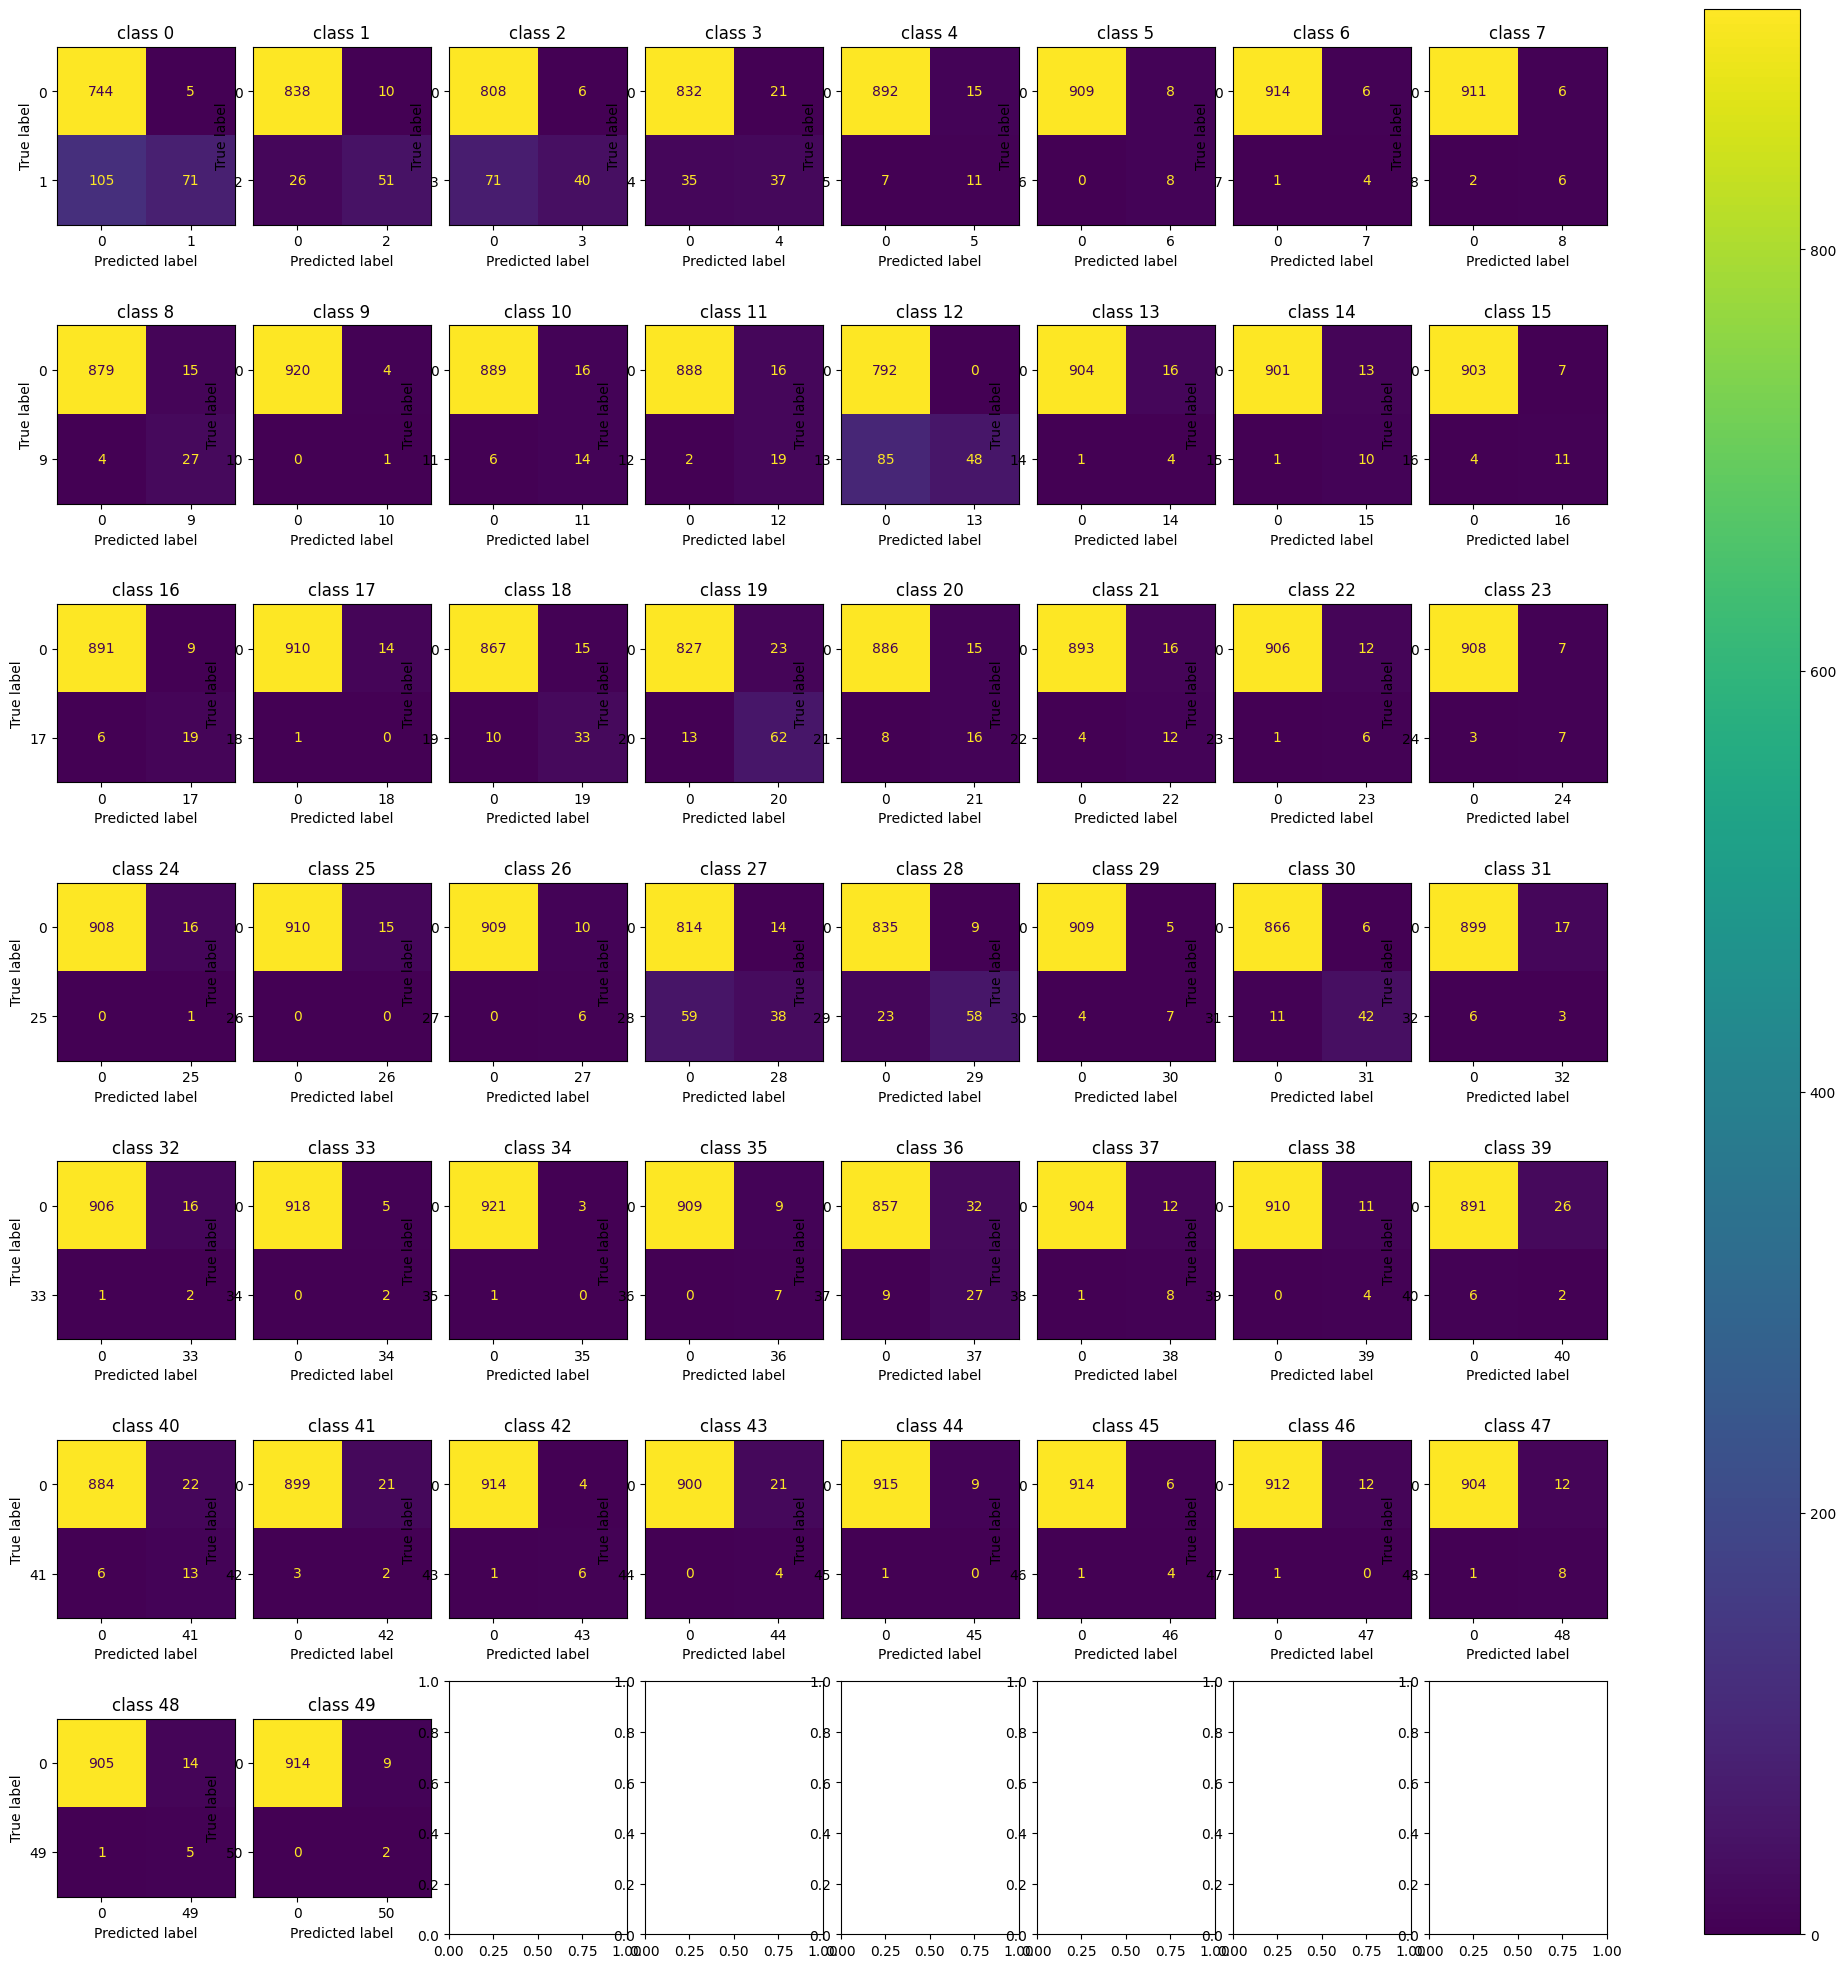

In [209]:
f, axes = plt.subplots(7, 8, figsize=(25, 25))
axes = axes.ravel()
for i in range(50):
    disp = ConfusionMatrixDisplay(confusion_matrix(np.array(true_classes)[:, i], np.array(preds)[:, i]),
                                  display_labels=[0, i+1])
    disp.plot(ax=axes[i], values_format='.4g')
    disp.ax_.set_title(f'class {i}')
    # if i<10:
    #     disp.ax_.set_xlabel('')
    # if i%8!=0:
    #     disp.ax_.set_ylabel('')
    disp.im_.colorbar.remove()

plt.subplots_adjust(wspace=0.10, hspace=0.1)
f.colorbar(disp.im_, ax=axes)
plt.show()

In [42]:
pred_idx = 9
print(true_classes[pred_idx])
print(preds[pred_idx].tolist())

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


In [23]:
CLASSES2FULLTRENDS

{0: 'Долгая доставка. - долго везёте\n- очень долго везёте\n- сюда относим замечания без конкретики\n',
 1: 'Доставка стала долгой. - клиент делает акцент на то, что раньше мы доставляли быстрее',
 2: 'Время доставки не соответствует заявленому. - клиент акцентирует внимание, что SLA не соотвесвует реальному времени доставки (всегда или часто)\n- в комментарии указывать, если клиент акцентирует внимание, что мы НИКОГДА не выдерживаем заявленное время доставки',
 3: 'Регулярные опоздания. - клиент акцентриет внимание, что мы часто/каждый заказ привозим заказ с опозданием',
 4: 'Не отследить реальное время доставки. - клиент говорит о том, что невозможно понять, когда приедет заказ\n- нет реального времени доставки\n- клиент задает вопрос "где заказ"/"долго ли ждать"',
 5: 'Курьер на карте. - если клиент упоминает отображение курьера на карте (даже если мы предполагаем, что он просто хочет понимать, когда будет заказ)',
 6: 'Нет доставки по адресу. клиент жалутеся, что нет доставки по ад

In [ ]:
{0: 'Долгая доставка. - долго везёте\n- очень долго везёте\n- сюда относим замечания без конкретики\n',
 1: 'Доставка стала долгой. Клиент делает акцент на то, что раньше мы доставляли быстрее',
 2: 'Время доставки не соответствует заявленому. - клиент акцентирует внимание, что SLA не соотвесвует реальному времени доставки (всегда или часто)\n- в комментарии указывать, если клиент акцентирует внимание, что мы НИКОГДА не выдерживаем заявленное время доставки',
 3: 'Регулярные опоздания. - клиент акцентриет внимание, что мы часто/каждый заказ привозим заказ с опозданием',
 4: 'Не отследить реальное время доставки. - клиент говорит о том, что невозможно понять, когда приедет заказ\n- нет реального времени доставки\n- клиент задает вопрос "где заказ"/"долго ли ждать"',
 5: 'Курьер на карте. - если клиент упоминает отображение курьера на карте (даже если мы предполагаем, что он просто хочет понимать, когда будет заказ)',
 6: 'Нет доставки по адресу. клиент жалутеся, что нет доставки по адресу',
 7: 'Не предупреждаем об удалении товара. - не предупреждаем об удалении товара\n- не предлагаем замену товара',
 8: 'Высокая минимальная сумма заказа. клиент жалуется на размер минимальной суммы заказа',
 9: 'Сумма заказа меняется во время набора корзины. - сумма заказа меняется во время набора корзины \n- приходится несколько раз докладывать товары до мин суммы',
 10: 'Минимальная сумма заказа. - клиент жалуется на наличие минимальной суммы в принципе\nНапример, говорит, что не может заказать 1 товар.\n- минимальная сумма заказа постоянно меняется',
 11: 'Товары с подходящим сроком годности. - клиент жалуется, что мы привозим товары с практически истекшим сроком годнос\n- в комментарии прописывать, если клиент упоминает, что это был товар по акции',
 12: 'Высокие цены. - клиент жалуется на высокие цены\nв коментариях помечать если:\n- клиент упомианет конркетную категорию товаров (например, фрукты и овощи)\n- сравнивают нас с магазинами, говорят о наценке в сравнении с другими',
 13: 'Не довезли товар. - клиент говорит о том, что недовезли товар, без упоминания по какой причине\n- если товар удалили из заказа —\xa0то это тенденция "не предупреждаем об удалении товара"',
 14: 'Товар испорчен во время доставки. клиент жалуется, что:\n- побили яйца\n- разлился йогрут и т.д.\nлюбые повереждения товара во время доставки',
 15: 'Просроченные товары. привезли товар с истекшим сроком годности',
 16: 'Замечания по работе курьеров. - хамят\n- не читают комментарии\n- не понимают русский язык\n- не доносят заказ до двери\nи т.д.',
 17: 'Не читаем комментарии. - клиент жалуется на то, что мы не выполнили комментарий (без кпоминания курьера)\n- если говорят, о том, что курьер не прочитал комментарий —\xa0относим к категории "заменчания по работе курьера"',
 18: 'Спасибо. клиент благодарит сервис, в любом формате\n- молодцы так деражть\n- все круто\n- 👍🏻',
 19: 'Нет смысла. - обращения смысл, которых не ясен или его нет',
 20: 'Всё нормально. клиент нейтрально оценивать сервис\n- все норм\n- нормально\n- устраивает',
 21: 'Всё плохо. негативные комментарии без конкретики',
 22: 'Скидки для постоянных клиентов. клиенты говорят о том, что у нас нет:\n- скидко для постоянных клиентов\n- скидок на следующий заказ\n- программы лояльности',
 23: 'Больше акций/скидок. клиент говорит, что нужно больше акций/скидок/промокодов\nв комментарии помечать есть:\n- говорят о том, что не хватает скидко на всю корзину\n- редко запускаем акцию "товар за 1 рубль"',
 24: 'Скидка/промокод распространяется не на все товары. - по сути это жалоба на не суммирование\n- клиент жалуется, что на товары со скидкой с витрине, не применяется корзинная скидка\n- что корзинная скидка применяется только к каой-то категории товаров',
 25: 'Непонятно как работает скидка. - не поянтно какая скикдка применилась в корзине\n- не понятно почему скидка применилась не ко всем товарам\n- не понятно к каким товарам применилась скидка',
 26: 'Не сработала скидка/акция/промокод. - клиент жалуется на то, что не работает скидка\n- в комментарии помечать, если есть какая-то конркетика',
 27: 'Качество товаров. клиент жалуктся на качестова товаро\nв комменатрии помечать какой именно параметр:\n- свежесть/вялость\n- спелось\n- категорию товара',
 28: 'Маленький ассортимент. - жалобы на маленький ассортимент\n- комментарии указывать на какую категорию товаров',
 29: 'Нет в наличии товара. - жалобы на то, что в наличии нет товаров, которые есть у нас в ассортименте\n- товары быстро заканчиваются\n- нет завоза на цфз\nв комментариях помечать какие-то особенности.\nНапример:\n- ничего нет вечером\n- хотят уведомление о поступлении\n- не понимают поступит ли товар снова на ЦФЗ\n- Клиент переходит по банеру о скидке, а товар раскупили',
 30: 'Качество поддержки. любые замечания по работе поддрежки:\n- медленно отвечаем\n- бот не переключает на оператора\n- закрываем обращения не разобравшись и т.д.',
 31: 'Замечания по работе сборщика. - кладём несовместимые продукты в один пакет (химию в продуктами, корм для животных с продуктами и т.п.)\n- не используем термопакеты для замороженных продуктов\n- кладём не то (путаем товары)',
 32: 'Отменили заказ. - клиент жалуетя на то, что его заказ отменили\nв комментариях помечать, что до этого клиент ждал/долго ждал\n- заказ отменили, до передачи курьеру',
 33: 'Знание русского языка. - курьеры не понимают/не читают/не говорят по-русски',
 34: 'Привезли чужой заказ. - перепутали заказ',
 35: 'Долго на сборке. - долго собираем заказ\n- прошло уже 30 минут, а заказ ещё не передали курьеру\n- почти час ждём, а курьер ещё не вышел',
 36: 'Сравнивают с конкурентами. - сравнение с другими сервисами доставки продуктов\nв комментраии указывать с какими',
 37: 'Скидки за опоздание. - просят скидки/компенсацию\n- отмечать в коментариях, если просят назначать их атвоматически ',
 38: 'Курьеры отменяют заказ. - клиенты жалуются, что курьер отменил заказ',
 39: 'Не тянет на тенденцию. Ставим там, где не подходит ни под одну тенденцию.',
 40: 'Испорченные товары. - привозим продукты в сроке годности, но они испорчены\nв комментарии указываем категорию (овощи, фрукты, мясо, молочка, готовая еда и тп.п)',
 41: 'Не нравится интерфейс приложения. - просто не нравится приложение',
 42: 'Приложение зависает. - приложение работает не стабильно, зависает',
 43: 'Быстрая доставка. - быстро доставляем',
 44: 'Условия работы курьеров. - повысить ставку курьерам\n- одеть потеплее и т.п.',
 45: 'СберСпасибо. - сложности при подключении\n- периодически не оплатить бонусами\n- любые комменты по СберСпасибо',
 46: 'Время работы. - рано закрываемся\n- круглосуточная доставка\n- сделайте доставку с Х часов',
 47: 'Неудобный поиск. - неудобный поиск\n- не нравится навигация по каталогу\n- не нравится структура каталога (сторисы в каталоге, акции среди товаров и т.п.)',
 48: 'Платежи. - жалобы на проведение платежей\n- оплата курьеру наличными или картой\n- проблемы с оплатой\n- СБП\n- отображение карты\n- любые комменты по картам\n- не проходят платежи\n- чеки, квитанции',
 49: 'Возврат денег. - жалуются на долгие возвраты\n- жалуются, что не вернули деньги'}

In [70]:
text_emb = np.array([embed_bert_cls(x, model, tokenizer) for x in df['text']])
labels_emb = np.array([embed_bert_cls(x, model, tokenizer) for x in CLASSES2FULLTRENDS.values()])

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


In [71]:
cosine_similarity(embed_bert_cls(df['text'][2], model, tokenizer).reshape(1, -1), labels_emb), df['target'][2]

(array([[0.9171519 , 0.7336717 , 0.73540086, 0.8346853 , 0.7736642 ,
         0.8128346 , 0.8826395 , 0.78635514, 0.50952816, 0.8531273 ,
         0.7935337 , 0.81309825, 0.83490264, 0.7123396 , 0.7532389 ,
         0.8467972 , 0.9642748 , 0.81809306, 0.76322424, 0.9020085 ,
         0.7828091 , 0.87830365, 0.65338945, 0.78267694, 0.65122724,
         0.75906557, 0.6646525 , 0.8554353 , 0.7599497 , 0.94099903,
         0.9638566 , 0.8866452 , 0.8562592 , 0.8369456 , 0.73457944,
         0.78455293, 0.697154  , 0.91321963, 0.58446234, 0.9815803 ,
         0.8042309 , 0.7854195 , 0.8415098 , 0.98471713, 0.95803404,
         0.72804594, 0.79687226, 0.84563273, 0.830601  , 0.77009976]],
       dtype=float32),
 '[3]')

In [ ]:
preds = []
        true_classes = []
        for row_idx, row in tqdm(val_df.iterrows()):
            text = row['text']
            true_classes.append([int(x) for x in row[CLASSES].values.tolist()])
            probas = predict_zero_shot(text, classes, model, tokenizer, normalize=False)
            preds.append((probas > 0.5) + 0)
        acc = accuracy_score(true_classes, preds)
        print(acc)

In [ ]:
# from sklearn.multioutput import ClassifierChain
# from sklearn.linear_model import LogisticRegression
# from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
# from sklearn.metrics import jaccard_score
# from sklearn.multiclass import OneVsRestClassifier
# from sklearn.neural_network import MLPClassifier
# from xgboost import XGBClassifier
# from tqdm import tqdm


# # model = XGBClassifier(
# #     learning_rate=0.02,
# #     n_estimators=10,
# #     objective="binary:logistic",
# #     nthread=3,
# #     tree_method="hist",
# #     device='cuda',
# # )


# X_train = [x['input'].numpy() for x in train_data]
# y_train = [x['label'] for x in train_data]
# X_val = [x['input'].numpy() for x in val_data]
# y_val = [x['label'] for x in val_data]

# base_lr = MLPClassifier()
# ovr = OneVsRestClassifier(base_lr)
# ovr.fit(X_train, y_train)

# chains = [ClassifierChain(base_lr, order='random', random_state=i) for i in range(5)]
# for chain in tqdm(chains):
#     chain.fit(X_train, y_train)
